# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of layers failed: Traceback (most recent call last):
  File "d:\projects\2022\dlcourse_ai-master\assignments\assignment2\venv\lib\site-packages\IPython\extensions\autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "d:\projects\2022\dlcourse_ai-master\assignments\assignment2\venv\lib\site-packages\IPython\extensions\autoreload.py", line 455, in superreload
    module = reload(module)
  File "C:\Users\Alexey\AppData\Local\Programs\Python\Python39\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "D:\Projects\2022\dlcourse_ai-master\assignments\assignment2\layers.py", line 3, in <module>
    from assignments_in_progress.assignment1.linear_classifer import softmax, cross_entropy_loss
ModuleNotFo

In [44]:
import sys
sys.path.append('C:/Users/N1keFan/noteboook/dlcourse_ai')
PATH_TO_DATA = 'D:/Projects/2022/dlcourse_ai-master/assignments/assignment2/data'

In [45]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [46]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn(PATH_TO_DATA, max_train=10000, max_test=1000)
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [47]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [48]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [49]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for 0_W
Gradient check passed!
Checking gradient for 0_B
Gradient check passed!
Checking gradient for 2_W
Gradient check passed!
Checking gradient for 2_B
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [50]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for 0_W
Gradient check passed!
Checking gradient for 0_B
Gradient check passed!
Checking gradient for 2_W
Gradient check passed!
Checking gradient for 2_B
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [51]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.1

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [52]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Epoch: 0 Loss: 2.302029, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 1 Loss: 2.301685, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 2 Loss: 2.301851, Train accuracy: 0.148222, val accuracy: 0.140000
Epoch: 3 Loss: 2.302623, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 4 Loss: 2.302031, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 5 Loss: 2.301124, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 6 Loss: 2.302831, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 7 Loss: 2.301638, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 8 Loss: 2.302170, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 9 Loss: 2.302117, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 10 Loss: 2.302455, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 11 Loss: 2.302807, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 12 Loss: 2.302832, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 13 Loss: 2.302390, Train acc

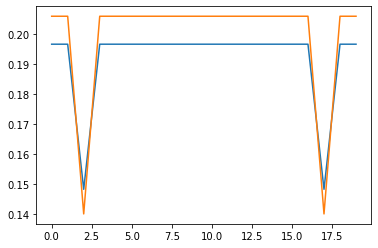

In [53]:
plt.plot(train_history)
plt.plot(val_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [54]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Epoch: 0 Loss: 2.275985, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 1 Loss: 2.347515, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 2 Loss: 2.264348, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 3 Loss: 2.287890, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 4 Loss: 2.253264, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 5 Loss: 2.265011, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 6 Loss: 2.212698, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 7 Loss: 2.320777, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 8 Loss: 2.302624, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 9 Loss: 2.311032, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 10 Loss: 2.234316, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 11 Loss: 2.283390, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 12 Loss: 2.353994, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 13 Loss: 2.217454, Train acc

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [55]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Epoch: 0 Loss: 2.322051, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 1 Loss: 2.308033, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 2 Loss: 2.317549, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 3 Loss: 2.262630, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 4 Loss: 2.270323, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 5 Loss: 2.308261, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 6 Loss: 2.264990, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 7 Loss: 2.278636, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 8 Loss: 2.267083, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 9 Loss: 2.279901, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 10 Loss: 2.276510, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 11 Loss: 2.314133, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 12 Loss: 2.256404, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 13 Loss: 2.295822, Train acc

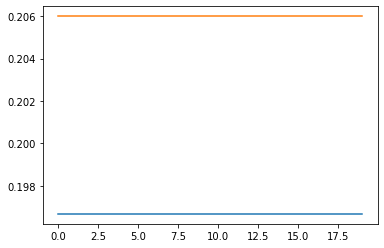

In [56]:
plt.plot(train_history)
plt.plot(val_history)

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [57]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Epoch: 0 Loss: 2.351801, Train accuracy: 0.200000, val accuracy: 0.133333
Epoch: 20 Loss: 2.022291, Train accuracy: 0.400000, val accuracy: 0.000000
Epoch: 40 Loss: 2.474042, Train accuracy: 0.666667, val accuracy: 0.066667
Epoch: 60 Loss: 2.022564, Train accuracy: 0.733333, val accuracy: 0.066667
Epoch: 80 Loss: 1.602167, Train accuracy: 0.866667, val accuracy: 0.066667
Epoch: 100 Loss: 1.887250, Train accuracy: 0.933333, val accuracy: 0.066667
Epoch: 120 Loss: 1.239065, Train accuracy: 0.933333, val accuracy: 0.000000
Epoch: 140 Loss: 1.445285, Train accuracy: 1.000000, val accuracy: 0.000000


Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [58]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 5e-3)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, MomentumSGD(momentum=0.3), learning_rate=6e-1, num_epochs=20, batch_size=100)

loss_history, train_history, val_history = trainer.fit()

Epoch: 0 Loss: 2.304119, Train accuracy: 0.200000, val accuracy: 0.133333
Epoch: 1 Loss: 2.281649, Train accuracy: 0.200000, val accuracy: 0.133333
Epoch: 2 Loss: 2.254767, Train accuracy: 0.200000, val accuracy: 0.133333
Epoch: 3 Loss: 2.223267, Train accuracy: 0.266667, val accuracy: 0.000000
Epoch: 4 Loss: 2.161378, Train accuracy: 0.400000, val accuracy: 0.000000
Epoch: 5 Loss: 1.978694, Train accuracy: 0.400000, val accuracy: 0.000000
Epoch: 6 Loss: 1.740139, Train accuracy: 0.333333, val accuracy: 0.066667
Epoch: 7 Loss: 1.706577, Train accuracy: 0.333333, val accuracy: 0.133333
Epoch: 8 Loss: 1.691457, Train accuracy: 0.400000, val accuracy: 0.066667
Epoch: 9 Loss: 1.619932, Train accuracy: 0.466667, val accuracy: 0.066667
Epoch: 10 Loss: 1.368164, Train accuracy: 0.466667, val accuracy: 0.000000
Epoch: 11 Loss: 1.250269, Train accuracy: 0.600000, val accuracy: 0.133333
Epoch: 12 Loss: 1.231682, Train accuracy: 0.466667, val accuracy: 0.000000
Epoch: 13 Loss: 1.494643, Train acc

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [59]:
# Let's train the best one-hidden-layer network we can
from random import choice

n_iterations = 15
num_epochs = 10
learning_rates = [1e-4, 1e-3, 1e-2, 1e-1]
reg_strength = [1e-6, 1e-4, 1e-2]
learning_rate_decay = [0.888, 0.995, 0.999]
hidden_layer_size = [64, 128, 256]
batch_size = [64]
momentums = [0.1, 0.3, 0.5, 0.7, 0.9]

best_classifier = None
best_val_accuracy = 0
best_params = {}

loss_history = []
train_history = []
val_history = []

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above
for i in range(0, n_iterations):
    lr = choice(learning_rates)
    reg = choice(reg_strength)
    lrd = choice(learning_rate_decay)
    hs = choice(hidden_layer_size)
    bs = choice(batch_size)
    momentum = choice(momentums)

    model = TwoLayerNet(n_input=train_X.shape[1], n_output=10,
                        hidden_layer_size=hs, reg=reg)
    dataset = Dataset(train_X, train_y, val_X, val_y)
    trainer = Trainer(model, dataset, MomentumSGD(momentum=momentum), learning_rate=lr,
                      learning_rate_decay=lrd, num_epochs=num_epochs, batch_size=bs)

    print()
    print ("Cycle {}...".format(i+1))
    loss_hist, train_hist, val_hist = trainer.fit()

    if val_hist[-1] > best_val_accuracy:
        best_val_accuracy = val_hist[-1]
        best_classifier = model

        best_params['learning_rate'] = lr
        best_params['reg_strength'] = reg
        best_params['learning_rate_decay'] = lrd
        best_params['hidden_layer_size'] = hs
        best_params['batch_size'] = bs
        best_params['momentum'] = momentum

        loss_history = loss_hist
        train_history = train_hist
        val_history = val_hist


Cycle 1...
Epoch: 0 Loss: 2.292673, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 1 Loss: 2.218334, Train accuracy: 0.217222, val accuracy: 0.217000
Epoch: 2 Loss: 2.073955, Train accuracy: 0.269556, val accuracy: 0.272000
Epoch: 3 Loss: 2.316178, Train accuracy: 0.329778, val accuracy: 0.334000
Epoch: 4 Loss: 2.039900, Train accuracy: 0.371667, val accuracy: 0.379000
Epoch: 5 Loss: 1.750894, Train accuracy: 0.401556, val accuracy: 0.397000
Epoch: 6 Loss: 1.913793, Train accuracy: 0.438222, val accuracy: 0.426000
Epoch: 7 Loss: 1.889167, Train accuracy: 0.464222, val accuracy: 0.468000
Epoch: 8 Loss: 1.785728, Train accuracy: 0.499333, val accuracy: 0.509000
Epoch: 9 Loss: 1.652614, Train accuracy: 0.528000, val accuracy: 0.536000

Cycle 2...
Epoch: 0 Loss: 2.284719, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 1 Loss: 2.270807, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 2 Loss: 2.249561, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 3 Loss:

In [60]:
print('Best params:', best_params)
print('best validation accuracy achieved: %f' % best_val_accuracy)

Best params: {'learning_rate': 0.1, 'reg_strength': 0.0001, 'learning_rate_decay': 0.999, 'hidden_layer_size': 256, 'batch_size': 64, 'momentum': 0.7}
best validation accuracy achieved: 0.726000


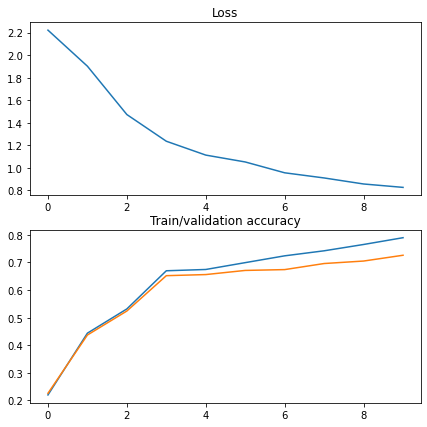

In [61]:
plt.figure(figsize=(7, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history);

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [62]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.662000
